# Parte I. Agrupamiento de Texto en Tópicos utilizando el algoritmo CorEx (Correlation Explanation)

**Integrantes - Grupo BSAC Covid 19 (Saturdays AI UIO)**
<table align="left">
  <tr>
    <td>Sandra Torres</td>
    <td>Wendy Jara</td>    
  </tr>
  <tr>
    <td>Edwin Rodriguez</td>
    <td>Christian Pichucho</td>
  </tr>
  <tr>
    <td>Jorge Vargas</td>
    <td>Milton Fonseca</td>
  </tr>
  <tr>
    <td>Sebastián Ayala</td>
    <!--<td bgcolor="LightGray">Coordinador</td>-->
    <td><i>*Coordinador</i></td>
  </tr> 
</table>

**Interactive Search Engine for Abstracts and Authors**
*by John David Parsons*  
https://www.kaggle.com/jdparsons/interactive-abstract-and-expert-finder/notebook

When a user enters a question (or we use the Kaggle-provided questions), the top-matching abstracts and authors are returned. I hope this is a useful tool for rapid information retrieval using natural language queries.

**DIRECTIONS:** Click the `Copy and Edit` button. With `load_preprocessed_file=True`, run all cells, and scroll to the bottom for the interactive widget. Takes about 90 seconds to fully load.

You will see an interactive widget (heavily inspired by this notebook:  
https://www.kaggle.com/dgunning/browsing-research-papers-with-a-bm25-search-engine):  

## 1. Preparación y Configuración

### 1.1 Montar Google Drive

In [ ]:
from google.colab import drive
path_drive = '/content/drive'

drive.mount(path_drive)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 1.2 Establecer Parámetros

In [ ]:
# Parámetros Generales
path_drive = '/content/drive/My Drive'

# Archivos a pre-cargar al arranque
file_final_df = 'df_final_covid_clean_topics.pkl'
file_final_topic_model = 'corex_topic_model.pkl'
file_metadata = 'metadata.csv'

# Flags
flag_use_google_drive = True
load_preprocessed_file = False # if set to False, the notebook takes about 10 minutes to run

folder_project = '/NLP/projects/interactive-abstract-and-expert-finder'
folder_cord = '/CORD-19-research-challenge/'

path_input_data = path_drive + folder_project + '/input/'
path_output_data = path_drive + folder_project + '/output/'
# Paths de Archivos de Entrada de Datos
path_in_topic_model = path_input_data + file_final_topic_model
path_in_dataframe = path_input_data + file_final_df
path_cord_metadata = path_drive + folder_cord + file_metadata
# Paths de Archivos de Salida de Datos
path_out_topic_model = path_output_data + file_final_topic_model
path_out_dataframe = path_output_data + file_final_df

### 1.3 Instalar Módulos

In [ ]:
# https://github.com/gregversteeg/corex_topic
!pip install 'corextopic'

### 1.4 Importar Módulos

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import json
import pickle as pkl
import string
import nltk
import time
import multiprocessing
import numpy as np
import itertools
import collections
import random
import operator
import scipy.sparse as ss
import corextopic
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact

from corextopic import corextopic as ct
# jupyter notebooks will complain matplotlib is being loaded twice
from corextopic import vis_topic as vt 

from multiprocessing import Pool
from collections import Counter
from itertools import chain

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize#, word_tokenize
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from datetime import datetime

%matplotlib inline

### 1.5 Instalar Dependencias Adicionales de NLTK

In [ ]:
 nltk.download('punkt')
 nltk.download('averaged_perceptron_tagger')
 nltk.download('wordnet')
 nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 1.6 Cargar Datos

Load raw data, dedupe publications, and drop any publications that don't have an Abstract. Then create a new column "document" that is the "title" combined with "abstract".

In [ ]:
if load_preprocessed_file is False:

    # credit: https://www.kaggle.com/gkaraman/topic-modeling-lda-on-cord-19-paper-abstracts
    df = pd.read_csv(
        path_cord_metadata
        , dtype={
            'Microsoft Academic Paper ID': str
            ,'pubmed_id': str
        })

    print("Dataframe Initial Shape:", df.shape)

    # Some papers are duplicated since they were collected from separate sources. Thanks Joerg Rings
    duplicate_paper = ~(df.title.isnull() | df.abstract.isnull()) & (df.duplicated(subset=['title', 'abstract']))
    df = df[~duplicate_paper].reset_index(drop=True)
    print("Shape after deduplicating:", df.shape)

    # Borrar registros NaN de columna: 'abstract'
    df = df.dropna(subset=['abstract'])
    print("Shape after Droping NaN in 'abstract':", df.shape)
  
    # Borrar registros NaN de columna: 'title'
    df = df.dropna(subset=['title'])
    print("Shape after Droping NaN in 'title':", df.shape)

    # create a column that appends title+abstract. This column will be the "document" that all searching/clustering/vectorization will use
    df['document'] = df['title'] + '. ' + df['abstract']
    # 'document' ha presentado problemas al ejecutar la funcion 'clean'
    #df = df.dropna(subset=['document'])
    #print("Shape after Droping NaN in 'document':", df.shape)

    print("final shape:", df.shape)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataframe Initial Shape: (59887, 19)
Shape after deduplicating: (59793, 19)
Shape after Droping NaN in 'abstract': (48663, 19)
Shape after Droping NaN in 'title': (48510, 19)
final shape: (48510, 20)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48510 entries, 0 to 59792
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     48510 non-null  object
 1   sha                          39619 non-null  object
 2   source_x                     48510 non-null  object
 3   title                        48510 non-null  object
 4   doi                          45212 non-null  object
 5   pmcid                        41009 non-null  object
 6   pubmed_id                    36823 non-null  object
 7   license                      48510 non-null  object
 8   abstract                     48510 non-null  object
 9   publish_time                 48503 non-null  object
 10  authors                      48044 non-null  object
 11  journal                      42321 non-null  object
 12  Microsoft Academic Paper ID  633 non-null    object
 13  WHO #Covidence               12

## 2. Limpieza de Datos

### 2.1 Definición de Funciones Utilitarias y de StopWords (Palabras Vacías)

Each clean function can be tested independently.

#### 2.1.1 Limpiar Líneas: `clean_newlines(text)`

In [ ]:
# "supercalifragili-\nsticexpialidocious\nthis is a new line" -> "supercalifragilisticexpialidocious this is a new line"
def clean_newlines(text):
    text = text.replace('-\n', '')
    text = text.replace('\n', ' ').replace('\r',' ')
    
    return text

test = 'supercalifragili-\nsticexpialidocious\nthis is a new line '
clean_newlines(test)

'supercalifragilisticexpialidocious this is a new line '

#### 2.1.2 Limpiar Caracteres: `clean_chars(text)`

In [ ]:
def clean_chars(text):
    text = "".join(i for i in text if ord(i) < 128) # remove all non-ascii characters
    text = text.replace('\t', ' ') # convert a tab to space
    # fastest way to remove all punctuation (except ' . and !) and digits
    text = text.replace('[Image: see text]', '')
    text = text.translate(str.maketrans('', '', '"#$%&()*+,-/:;<=>@[\\]^_`{|}~' + string.digits))
    
    return text.strip()

clean_chars('[Image: see text] Numbers 123 are greater than 456?!\t"I\'m of the op1ni0n it isn\'t..."')

"Numbers  are greater than ?! I'm of the opnin it isn't..."

#### 2.1.3 Lematizador: `get_wordnet_pos(word)`

Lemmatize the sentence to normalize conjucations and pluralization.

In [ ]:
# credit: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
# helper correctly accounts for the same word having a different
# part-of-speech depending on the context of its usage
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

sentence = "The ten foot striped bats are hanging on their good better best feet. The bat's wings were ten feet wide."

print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

['The', 'ten', 'foot', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'good', 'well', 'best', 'foot', '.', 'The', 'bat', "'s", 'wing', 'be', 'ten', 'foot', 'wide', '.']


#### 2.1.4 De-duplicator: `dedupe_sentences(sentences)`

Dedupe sentences within a document, just in case the article title is also the first sentence of the abstract, or opening sentence of text_body.

In [ ]:
def dedupe_sentences(sentences):
    deduped = []
    for s in sentences:
        if s not in deduped:
            deduped.append(s)
    
    return deduped

test_sentences = [
    ['see', 'figure', 'for', 'data'],
    ['not', 'cleared', 'for', 'release'],
    ['new', 'sentence', 'here'],
    ['see', 'figure', 'for', 'data'],
    ['not', 'cleared', 'for', 'release'],
    ['finally']
]

print("Original Number of Sentences after Deduplication:", len(test_sentences))
#print("Original dimensions of Sentences:", [f"Sentence[{i}]: # of words={len(v)}" for i, v in enumerate(test_sentences)] )
#print("Original dimensions of Sentences:", [(i, len(v)) for i, v in enumerate(test_sentences)] )

clean_sentences = dedupe_sentences(test_sentences)

print("Number of Sentences after Deduplication:", len(clean_sentences))

Original Number of Sentences after Deduplication: 6
Number of Sentences after Deduplication: 4


#### 2.1.5 Stop Words

Define stopwords that will be removed from all text. For example: "and", "it", "the", "thus"

In [ ]:
stpwrds_list = stopwords.words('english')

# add custom stopwords here, discovered from most common words and ngrams (further below)
stpwrds_list += ['...', 'also', 'could', 'thus', 'therefore']

stpwrds_lower = [wrd.lower() for wrd in stpwrds_list]

stpwrds_list += stpwrds_lower

stpwrds = set(stpwrds_list) # dedupes stopwords

#### 2.1.6 Función global de Limpieza de Datos: `clean(text, min_word_len=3, lower=True)`

Wrapper function that calls all the previously-defined functions.

In [ ]:
# given a string representing an entire document, returns the following format where all the words are non-stopwords and lemmatized:
#example = [
#    ['Sentence', 'one', 'words'],
#    ['Sentence', 'two', 'words']
#]

def clean(text, min_word_len=3, lower=True):
  checkpoint = 0
  try:
    #print('Checkpoint 1')
    checkpoint = 1
    if (lower is True):
        text = text.lower()
    
    #print('Checkpoint 2')
    checkpoint = 2
    text = clean_newlines(text)
    #print('Checkpoint 3')
    checkpoint = 3
    text = clean_chars(text)
    
    #print('Checkpoint 4')
    checkpoint = 4
    sentences = sent_tokenize(text)
    
    clean_sentences = []
    
    #print('Checkpoint 5')
    checkpoint = 5
    for s in sentences:
        clean_sent_words = [
            lemmatizer.lemmatize(w, get_wordnet_pos(w))
            for w in nltk.word_tokenize(s)
            # skip short words, contraction parts of speech, and storwords')
            if len(w) >= min_word_len and w[0] != '\'' and w not in stpwrds
        ]
        
        clean_sentences.append(clean_sent_words)
    
    #print('Checkpoint 6')
    checkpoint = 6
    # one and only one identical sentence is allowed per document
    # this helps avoid common phrases like "Table of data below:" appearing
    # many times, which will skew the word associations
    clean_sentences = dedupe_sentences(clean_sentences)
    
    #print('Checkpoint 7')
    checkpoint = 7
    return clean_sentences
  except Exception as ex:
    print("Error with text: ", text, "\nCheckpoint #:", checkpoint, "\nException: ", ex)

test = " NOT CLEARED FOR PUBLIC RELEASE. See table for references. The ss goes here. "
test += "US interests. U.S. Enterprise. The ten foot striped bats are hanging on their good better best feet. The "
test += "bat's Wings were ten feet wide. Is the U.S. Enterprise 123 better than 456?!\t\"I\'m of the op1ni0n it isn\'t...\""
test += " New sentence. NOT CLEARED FOR PUBLIC RELEASE. See table for references."
clean(test)

[['clear', 'public', 'release'],
 ['see', 'table', 'reference'],
 ['go'],
 ['interest'],
 ['u.s.', 'enterprise'],
 ['ten', 'foot', 'strip', 'bat', 'hang', 'good', 'well', 'best', 'foot'],
 ['bat', 'wing', 'ten', 'foot', 'wide'],
 ['u.s.', 'enterprise', 'well'],
 ['opnin', "n't", 'new', 'sentence']]

### 2.2 Aplicar función global de limpieza de datos `clean(text)` a la columna `document`

In [ ]:
df['document'].describe()

count                                                 48510
unique                                                48510
top       Intracellular human antibody fragments recogni...
freq                                                      1
Name: document, dtype: object

In [ ]:
#https://datatofish.com/check-nan-pandas-dataframe/
# (1) Check for NaN under a single DataFrame column:
df['document'].isnull().values.any()

False

In [ ]:
# (2) Count the NaN under a single DataFrame column:
df['document'].isnull().sum()

0

In [ ]:
%%time

print("Number of Cores:", multiprocessing.cpu_count())

# https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def parallelize_dataframe(df, func, n_cores=multiprocessing.cpu_count()):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    return df

def clean_dataframe(df):
    df['clean'] = df.apply(lambda x: clean(x['document']), axis=1)
    print(df.info())
    return df

if load_preprocessed_file is False:  
    # this parallelize_dataframe way takes about 7 minutes
    df = parallelize_dataframe(df, clean_dataframe)

    # the "swifter" keyword/library aims to make dataframe processing faster, but it didn't help in this case
    # !pip install 'swifter'
    # import swifter
    # https://towardsdatascience.com/add-this-single-word-to-make-your-pandas-apply-faster-90ee2fffe9e8
    # this method was slower at 17 minutes in total, but it provided a nice progress bar and countdown timer
    # df['clean'] = df.swifter.apply(lambda x: clean(x['document']), axis=1)

    df[['clean']].head(3)
else:
    df = pkl.load(open(path_dataframe, "rb" ))

Number of Cores: 2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24255 entries, 26596 to 59792
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     24255 non-null  object
 1   sha                          20105 non-null  object
 2   source_x                     24255 non-null  object
 3   title                        24255 non-null  object
 4   doi                          20957 non-null  object
 5   pmcid                        16754 non-null  object
 6   pubmed_id                    13635 non-null  object
 7   license                      24255 non-null  object
 8   abstract                     24255 non-null  object
 9   publish_time                 24248 non-null  object
 10  authors                      23873 non-null  object
 11  journal                      18206 non-null  object
 12  Microsoft Academic Paper ID  633 non-null    object
 13  WHO #Cov

### 2.3 Identificación de StopWords adicionales en la columna `document`

Identify the most common words. If you identify some words as low-value, add them to the stopwords list above and rerun the cells until this point. Repeat until you are happy with the words that are left.

In [ ]:
clean_words = df['clean'].tolist()
clean_words = [item for sublist in clean_words for item in sublist]

print(str(len(clean_words)) + ' total words in corpus')

counter_obj = Counter(chain.from_iterable(clean_words))
word_counts = counter_obj.most_common()
word_counts.sort(key=operator.itemgetter(1), reverse=True)

word_counts[0:10]

482481 total words in corpus


[('virus', 77361),
 ('infection', 52102),
 ('cell', 44369),
 ('disease', 38929),
 ('use', 38144),
 ('study', 36228),
 ('protein', 35576),
 ('viral', 32695),
 ('patient', 31990),
 ('respiratory', 30764)]

*NOTA*

Esta es la lista de las top 10 palabras más recurrentes.

    482481 total words in corpus
    [('virus', 77361),
    ('infection', 52102),
    ('cell', 44369),
    ('disease', 38929),
    ('use', 38144),
    ('study', 36228),
    ('protein', 35576),
    ('viral', 32695),
    ('patient', 31990),
    ('respiratory', 30764)]

De las mismas, talvez la palabra **`use`** (con `38144` ocurrencias) podría ser considerada como **stopword**?

## 3. Procesamiento de Datos

Identificar *bi-gramas* y *tri-gramas*. Ejemplo: con frecuencia, las palabras `"salud"` y `"pública"` aparecen una al lado de la otra, por lo tanto, debe considerarse un bi-grama `"salud_pública"`.

### 3.1 Identificar `bi-gramas` y `tri-gramas`

In [ ]:
%%time
# higher threshold means fewer ngrams - open question, how to optimize these hyperparams?

bigram = Phrases(clean_words, min_count=384, threshold=64, delimiter=b'_')
trigram = Phrases(bigram[clean_words], min_count=64, threshold=32, delimiter=b'_')

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 50 s, sys: 100 ms, total: 50.1 s
Wall time: 50.2 s


**WARNING:**  

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the **gensim.models.phrases.Phraser class**

### 3.2 Mostrar todos los bi-gramas y tri-gramas

In [ ]:
sorted(
    {k:v for k,v in trigram.vocab.items() if b'_' in k if v>=trigram.min_count and str(k).count('_') == 2 }.items(),
    key=operator.itemgetter(1),
    reverse=True
)

[(b'severe_acute_respiratory', 5000),
 (b'middle_east_respiratory', 2323),
 (b'polymerase_chain_reaction', 1589),
 (b'infectious_bronchitis_virus', 1259),
 (b'central_nervous_system', 1040),
 (b'intensive_care_unit', 891),
 (b'contains_supplementary_material', 806),
 (b'material_available_authorize', 806),
 (b'available_authorize_user', 806),
 (b'innate_immune_response', 788),
 (b'open_reading_frame', 768),
 (b'porcine_reproductive_respiratory', 762),
 (b'transmissible_gastroenteritis_virus', 688),
 (b'enzymelinked_immunosorbent_assay', 604),
 (b'amino_acid_sequence', 528),
 (b'public_health_emergency', 499),
 (b'herpes_simplex_virus', 484),
 (b'vesicular_stomatitis_virus', 373),
 (b'west_nile_virus', 346),
 (b'avian_infectious_bronchitis', 338),
 (b'basic_reproduction_number', 324),
 (b'critically_ill_patient', 313),
 (b'version_article_doi.s', 296),
 (b'doi.s_contains_supplementary', 296),
 (b'angiotensinconverting_enzyme_ace', 275),
 (b'global_public_health', 268),
 (b'peripheral_bl

### 3.3 Reemplazar los `n-gramas`

#### 3.3.1 Función Utilitaria para Obtener los n-gramas de un texto: `get_ngram_words(sent_arr)`

In [ ]:
def get_ngram_words(sent_arr):
    result = []

    for s in sent_arr:
        sent_result = []
        for w in trigram[bigram[s]]:
            if (w not in stpwrds): # we need to check again, because we may have added ngrams to the stopword list
                sent_result.append(w)

        result.append(sent_result)
    return result

test_sentences = [
    ['polymerase', 'chain', 'reaction'],
    ['infectious', 'disease', 'cause', 'unknown', 'public', 'health'],
    ['significant', 'acute', 'respiratory', 'disease', 'report', 'world', 'health']
]

get_ngram_words(test_sentences)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[['polymerase_chain_reaction'],
 ['infectious_disease', 'cause', 'unknown', 'public_health'],
 ['significant', 'acute', 'respiratory', 'disease', 'report', 'world_health']]

#### 3.3.2 Reemplazar los n-gramas en todos los documentos (title + abstract)

In [ ]:
%%time

def convert_ngram_dataframe(df):
    df['clean'] = df.apply(lambda x: get_ngram_words(x['clean']), axis=1)

    return df

if load_preprocessed_file is False:
    df = parallelize_dataframe(df, convert_ngram_dataframe)

    df[['clean']].head(3)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 6.41 s, sys: 1.8 s, total: 8.21 s
Wall time: 1min 6s


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48510 entries, 0 to 59792
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     48510 non-null  object
 1   sha                          39619 non-null  object
 2   source_x                     48510 non-null  object
 3   title                        48510 non-null  object
 4   doi                          45212 non-null  object
 5   pmcid                        41009 non-null  object
 6   pubmed_id                    36823 non-null  object
 7   license                      48510 non-null  object
 8   abstract                     48510 non-null  object
 9   publish_time                 48503 non-null  object
 10  authors                      48044 non-null  object
 11  journal                      42321 non-null  object
 12  Microsoft Academic Paper ID  633 non-null    object
 13  WHO #Covidence               12

In [ ]:
df[['cord_uid', 'document', 'clean']].head()

,cord_uid,document,clean
0,zjufx4fo,Sequence requirements for RNA strand transfer ...,"[[sequence, requirement, rna, strand, transfer..."
1,ymceytj3,"Crystal structure of murine sCEACAM1a[1,4]: a ...","[[crystal_structure, murine, sceacama, coronav..."
2,wzj2glte,Synthesis of a novel hepatitis C virus protein...,"[[synthesis, novel, hepatitis, virus, protein,..."
3,2sfqsfm1,Structure of coronavirus main proteinase revea...,"[[structure, coronavirus, main, proteinase, re..."
4,i0zym7iq,Discontinuous and non-discontinuous subgenomic...,"[[discontinuous, nondiscontinuous, subgenomic_..."


### 3.4 Análisis de Frecuencia

#### 3.4.1 Diccionario de Frecuencia de Palabras

Crear un diccionario de todas las palabras (`{palabra:frecuencia}`) para que podamos verificar las palabras de baja y alta frecuencia en todo el corpus.

In [ ]:
all_words = []
docs = []

for index, row in df.iterrows():
    sent_arr = row['clean']
    doc_words = []
    
    for s in sent_arr:
        for w in s:
            doc_words.append(w)
            all_words.append(w)
    
    docs.append(doc_words)

total_words = len(all_words)
unique_words = len(set(all_words))

print('TOTAL WORDS: ' + f"{total_words:,d}"  )
print('UNIQUE WORDS: ' + f"{unique_words:,d}" )

TOTAL WORDS: 5,833,949
UNIQUE WORDS: 143,781


#### 3.4.2 Filtrar Palabras

Filtre las palabras que aparecen en menos de `"no_below"` documentos, o más de `"no_above%"` de los documentos.

In [ ]:
%%time

# credit: https://www.kaggle.com/gkaraman/topic-modeling-lda-on-cord-19-paper-abstracts

# Create a dictionary representation of the documents
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=32, no_above=0.2)

# Create Bag-of-words representation of the documents
#corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
#print('Number of documents: %d' % len(corpus))


def remove_non_dict_words(sent_arr):
    result = []

    for s in sent_arr:
        for w in s:
            if w in dictionary.token2id:
                result.append(w)
                
    return result

def remove_non_dict_words_df(df):
    df['clean_tfidf'] = df.apply(lambda x: remove_non_dict_words(x['clean']), axis=1)

    return df

df = parallelize_dataframe(df, remove_non_dict_words_df)

# after all the processing, there are some gaps in the indices,
# so we reset them to make index counting easier later
df = df.reset_index() 

Number of unique tokens: 9089
CPU times: user 12.9 s, sys: 2.14 s, total: 15 s
Wall time: 22.3 s


Sin filtrado, tenemos alrededor de `143,781` tokens únicos. Con el filtrado tenemos alrededor de `9,089` tokens únicos que consideramos `"interesantes"`.

## 4. Modelamiento de Tópicos con CorEx


---



### 4.1 Entranamiento de modelo CorEx para generar Tópicos

Ahora se entrenará un modelo CorEx para generar tópicos (temas) para todo el corpus.

0: health,public_health,national,risk,policy,international,care,practice,medical,measure
1: patient,respiratory,child,clinical,acute,pneumonia,symptom,respiratory_tract,respiratory_syncytial,rhinovirus
2: binding,activity,inhibit,inhibitor,membrane,domain,inhibition,target,structural,residue
3: activation,mechanism,role,pathway,cellular,response,function,receptor,cytokine,signal
4: sequence,genome,gene,rna,nucleotide,strain,genomic,mutation,phylogenetic_analysis,genetic
5: diarrhea,pig,calf,animal,cat,porcine_epidemic,feline,central_nervous_system,pedv,intestinal
6: model,approach,base,apply,tool,application,prediction,dynamic,simulation,technology
7: detection,sample,detect,test,pcr,positive,specimen,assay,rtpcr,diagnostic
8: severe_acute_respiratory,sarscov,covid,syndrome_coronavirus,outbreak,coronavirus,sars,syndrome_sars,epidemic,middle_east_respiratory
9: mouse,expression,express,induced,ifn,induce,immune_response,induction,demonstrate,vivo
10: que,de,le,est,une,rsum,la,por,los,un

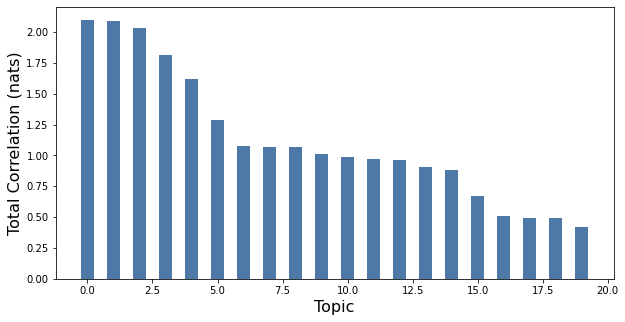

In [ ]:
%%time


if load_preprocessed_file is False:

    target_num_topics = 20 # tópicos a identificar por CorEx

    def dummy(doc):
        return doc

    vectorizer = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
    )  

    corex_docs = df['clean_tfidf'].tolist()
    doc_word = vectorizer.fit_transform(corex_docs)

    doc_word = ss.csr_matrix(doc_word)

    # Get words that label the columns (needed to extract readable topics
    # and make anchoring easier)
    words = list(np.asarray(vectorizer.get_feature_names()))

    #doc_word.shape # n_docs x m_words

    # https://github.com/gregversteeg/corex_topic
    # Train the CorEx topic model with x topics (n_hidden)
    topic_model = ct.Corex(n_hidden=target_num_topics, words=words, max_iter=500, verbose=False, seed=2020)

    topic_model.fit(doc_word, words=words)

    plt.figure(figsize=(10,5))
    plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
    plt.xlabel('Topic', fontsize=16)
    plt.ylabel('Total Correlation (nats)', fontsize=16);
    # no single topic should contribute too much.
    # If one does, that indicates more investigation for boilerplate text,
    # more preprocessing required.

    # To find optimal num of topics, we should keep adding topics until additional
    # topics do not significantly contribute to the overall TC
    
    pkl.dump(topic_model, open(path_out_topic_model, "wb"))
else:
    topic_model = pkl.load(open(path_in_topic_model, "rb" ))

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
topic_list = []

for n, topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
    topic_list.append('topic_' + str(n) + ': ' + ', '.join(topic_words))

In [ ]:
print("type(topics):", type(topics))
print("len(topics):", len(topics))
topics

type(topics): <class 'list'>
len(topics): 20


[[('health', 0.07819868863594989),
  ('public_health', 0.047379193897883566),
  ('national', 0.04701427268345163),
  ('risk', 0.046775351041916026),
  ('policy', 0.0439273024375846),
  ('international', 0.04352759900681843),
  ('care', 0.04023434762464224),
  ('practice', 0.036697040974408186),
  ('medical', 0.036401359257311756),
  ('measure', 0.035782878395272784)],
 [('patient', 0.15485459288984565),
  ('respiratory', 0.12153850117832599),
  ('child', 0.07954655572121214),
  ('clinical', 0.07797813266884773),
  ('acute', 0.07133336096940021),
  ('pneumonia', 0.061411567951009195),
  ('symptom', 0.06026015650904005),
  ('respiratory_tract', 0.05267492814517904),
  ('respiratory_syncytial', 0.04918432880240683),
  ('rhinovirus', 0.04347807305923954)],
 [('binding', 0.08487981563257542),
  ('activity', 0.07399665259932148),
  ('inhibit', 0.06402164406873423),
  ('inhibitor', 0.060225820339119746),
  ('membrane', 0.05039574144437599),
  ('domain', 0.050373571524239394),
  ('inhibition',

### 4.2 Asignar Puntaje de Probabilidad de correspondencia de Tópico

Iterar todos los documentos y asignar un puntaje de probabilidad de correspondencia de `tópico` a cada `documento`.

Estos puntajes serán usados más tarde para filtrar los resultados de `búsqueda por tópico`.

In [ ]:
%%time

if load_preprocessed_file is False:

    # remove any existing topic columns. This allows us to iterate on number of topics
    for c in [col for col in df.columns if col.startswith('topic_')]:
        del df[c]

    # TODO: inefficient code. Ideas to improve this: for each topic, first create a np array of
    # length of rows, then iterate over those indices setting the scores with the rest default to 0,
    # then set the whole df col
    for topic_num in range(0, len(topic_model.get_topics())):
        df['topic_' + str(topic_num)] = 999999.9

    for topic_num in range(0, len(topic_model.get_topics())):
        for ind, score in topic_model.get_top_docs(topic=topic_num, n_docs=9999999, sort_by='log_prob'):
            df['topic_' + str(topic_num)].iloc[ind] = score

    # finally save the dataframe so we can load it quicker in situations where we just want to interact with the results.

    pkl.dump(df, open(path_out_dataframe, "wb"))

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
NOTE: 'docs' not provided to CorEx. Returning top do

## 5. Vectorizar Documentos con TF-IDF

Ahora se entrenará el modelo TF-IDF, que utiliza la columna `clean_tfidf` como contenido para vectorizar.

In [ ]:
# because we are doing our own tokenization, we use a dummy function to bypass
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfidf_docs = df['clean_tfidf'].tolist()
tfidf_matrix = tfidf.fit_transform(tfidf_docs)

## 6. Widget Interactivo de Búsqueda

**Instrucciones:**

1. Escriba su propia pregunta en el cuadro de texto "query". El valor predeterminado es "cruise ship spread rate" ("tasa de propagación en cruceros").
2. Seleccione un tópico para filtrar el resultado.
2. Arrastre el control deslizante (slider) `topic_threshold` para filtrar los resultados que no se alinean fuertemente con el tópico.
  * Curiosamente, si baja el control deslizante de umbral hasta `-20`, con la consulta predeterminada de "tasa de propagación de cruceros" ("cruise ship spread rate"), el resultado superior no es lo que esperaría. Aparentemente, hay un acrónimo de mayúsculas `SHIP` que significa algo no relacionado con el barco. Esta es la razón por la cual los umbrales de tópico CorEx pueden ser útiles para filtrar estas inesperadamente buenas coincidencias TF-IDF.

Estas son algunas de las preguntas proporcionadas por Kaggle:

1. *What is known about transmission, incubation, and environmental stability?* 
What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?

> *¿Qué se sabe sobre transmisión, incubación y estabilidad ambiental?* ¿Qué sabemos sobre la historia natural, la transmisión y el diagnóstico del virus? ¿Qué hemos aprendido sobre prevención y control de infecciones?|

2. *What do we know about COVID-19 risk factors?*
What have we learned from epidemiological studies?

> *¿Qué sabemos sobre los factores de riesgo de COVID-19?* ¿Qué hemos aprendido de los estudios epidemiológicos?

3. *What do we know about virus genetics, origin, and evolution?* What do we know about the virus origin and management measures at the human-animal interface?

> *¿Qué sabemos sobre la genética, el origen y la evolución del virus?* ¿Qué sabemos sobre el origen del virus y las medidas de gestión en la interfaz humano-animal?

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

@interact
def search_articles(
    query='cruise ship spread rate',
    topic=topic_list,
    topic_threshold=(-20, 0, 0.01)
):
    clean_query_words = remove_non_dict_words(get_ngram_words(clean(query)))
    query_vector = tfidf.transform([clean_query_words])
    
    scores = cosine_similarity(query_vector, tfidf_matrix)[0]
    
    df['cosine_dist'] = scores

    # these are the ordered search results according to TF-IDF

    # smaller corex_topic scores means more likely to be of that topic
    corex_cols = [col for col in df if col.startswith('topic_')]
    select_cols = ['title', 'abstract', 'authors', 'cosine_dist'] + corex_cols
    
    results = df[select_cols].loc[df[topic.split(':')[0]] > topic_threshold].sort_values(by=['cosine_dist'], ascending=False).head(10)
    
    top_row = results.iloc[0]
    
    print('RESULTADO PRINCIPAL:\n')
    print('Título:', top_row['title'] + '\n')
    print('Resumen:', top_row['abstract'])
    
    print('\AUTORES:\n')
    print(top_row['authors'])
    
    return results

interactive(children=(Text(value='cruise ship spread rate', description='query'), Dropdown(description='topic'…